# Nama : Erdizah Ghodi Al Haidar
# NIM  : 24/537670/PA/22787
# Kelas: KOM

Akan dibuat fungsi untuk konversi gambar untuk disimpan dalam bentuk list 2D.

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import math

# ==== BASIC IMAGE CONVERSION ====
def img_to_gray_list(path_or_pil):
    if isinstance(path_or_pil, Image.Image):
        img = path_or_pil.convert('L')
    else:
        img = Image.open(path_or_pil).convert('L')
    w, h = img.size
    pixels = list(img.getdata())
    arr = [pixels[i*w:(i+1)*w] for i in range(h)]
    return arr, w, h

def list_to_img(bin_or_gray, mode='L'):
    h = len(bin_or_gray)
    w = len(bin_or_gray[0])
    flat = []
    if mode == 'L':
        for row in bin_or_gray:
            flat.extend([int(max(0,min(255,p))) for p in row])
    elif mode == '1':
        for row in bin_or_gray:
            flat.extend([255 if p else 0 for p in row])
    img = Image.new('L', (w, h))
    img.putdata(flat)
    return img

def show_images_grid(images, titles=None, figsize=(12,8), cmap='gray'):
    n = len(images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if isinstance(im, Image.Image):
            plt.imshow(im, cmap=cmap)
        else:
            plt.imshow(list_to_img(im), cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Load dan Konversi Gambar

Gambar diubah menjadi grayscale dan disimpan dalam bentuk list 2D agar bisa diproses tanpa library eksternal.

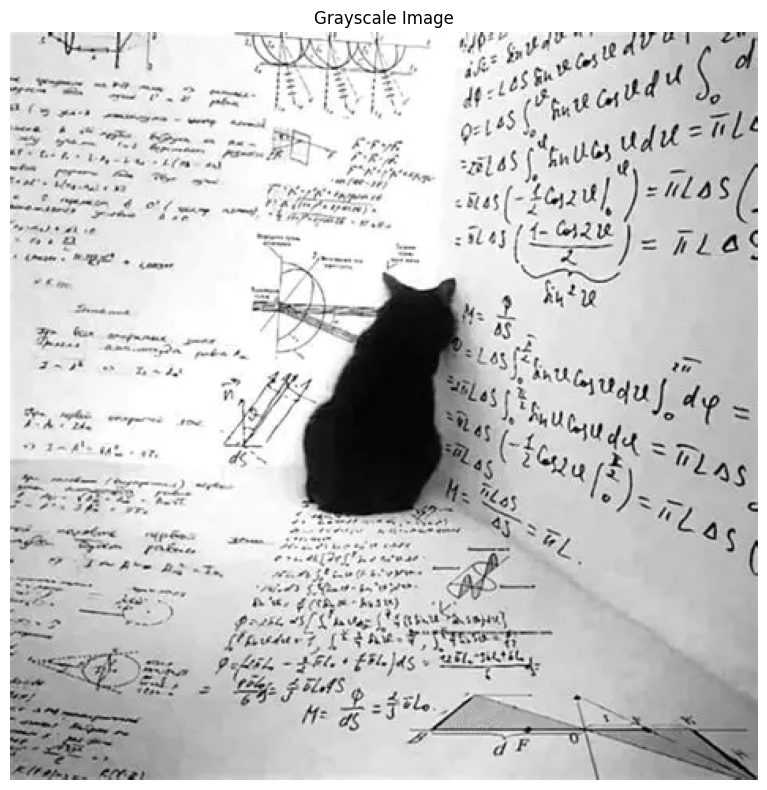

In [12]:
# Load grayscale
img_path = "/content/schrodinger_cat.webp"
gray_list, w, h = img_to_gray_list(img_path)
show_images_grid([gray_list], ["Grayscale Image"])


# Segmentasi

Empat metode segmentasi digunakan:

Thresholding: Pisahkan piksel berdasarkan nilai ambang.

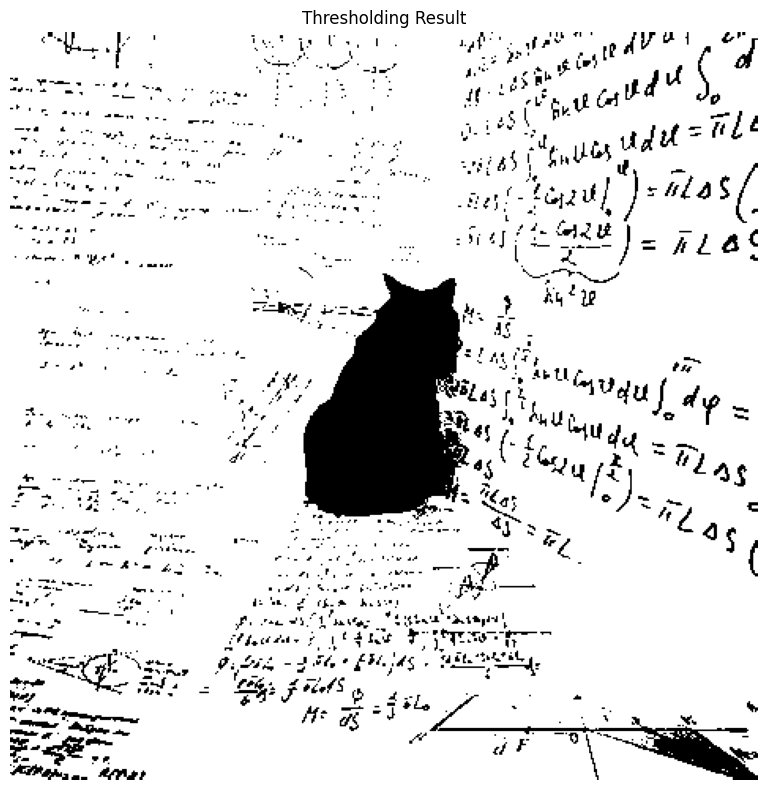

In [13]:
def threshold(img_list, T=128):
    h = len(img_list)
    w = len(img_list[0])
    result = [[255 if img_list[y][x]>T else 0 for x in range(w)] for y in range(h)]
    return result

seg_thresh = threshold(gray_list, 128)
show_images_grid([seg_thresh], ["Thresholding Result"])


Region Growing: Perluasan area berdasarkan kesamaan intensitas.

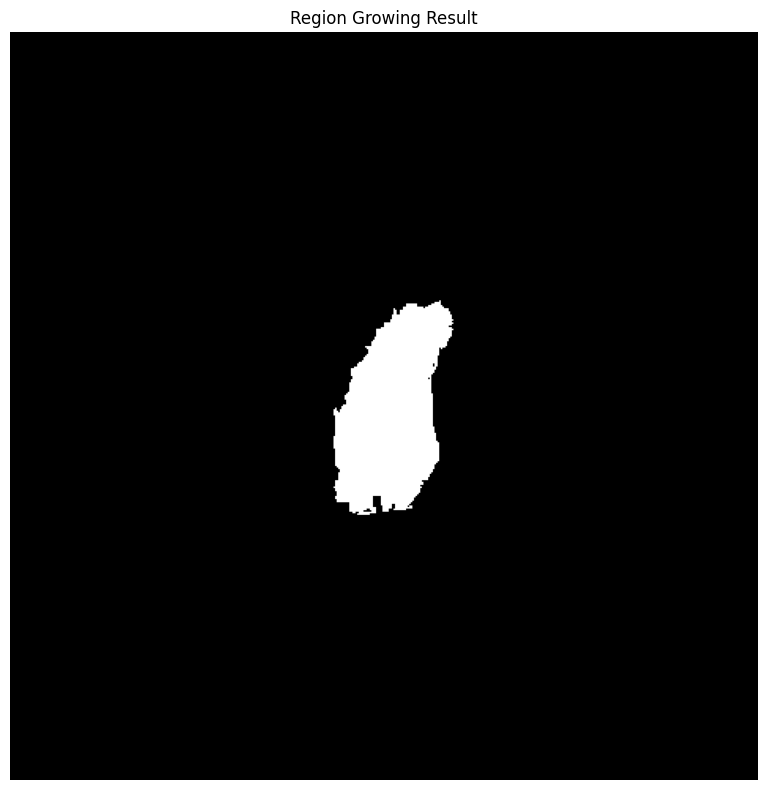

In [14]:
def region_grow(img, seed=(50,50), thresh=10):
    h = len(img); w = len(img[0])
    region = [[0]*w for _ in range(h)]
    visited = [[False]*w for _ in range(h)]
    stack = [seed]
    seed_val = img[seed[1]][seed[0]]
    while stack:
        x,y = stack.pop()
        if x<0 or x>=w or y<0 or y>=h or visited[y][x]: continue
        if abs(img[y][x]-seed_val)<=thresh:
            region[y][x]=255
            visited[y][x]=True
            for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                stack.append((x+dx,y+dy))
    return region

seg_rg = region_grow(gray_list, seed=(w//2,h//2))
show_images_grid([seg_rg], ["Region Growing Result"])


Flood Fill: Pewarnaan area dengan batas nilai ambang tertentu.

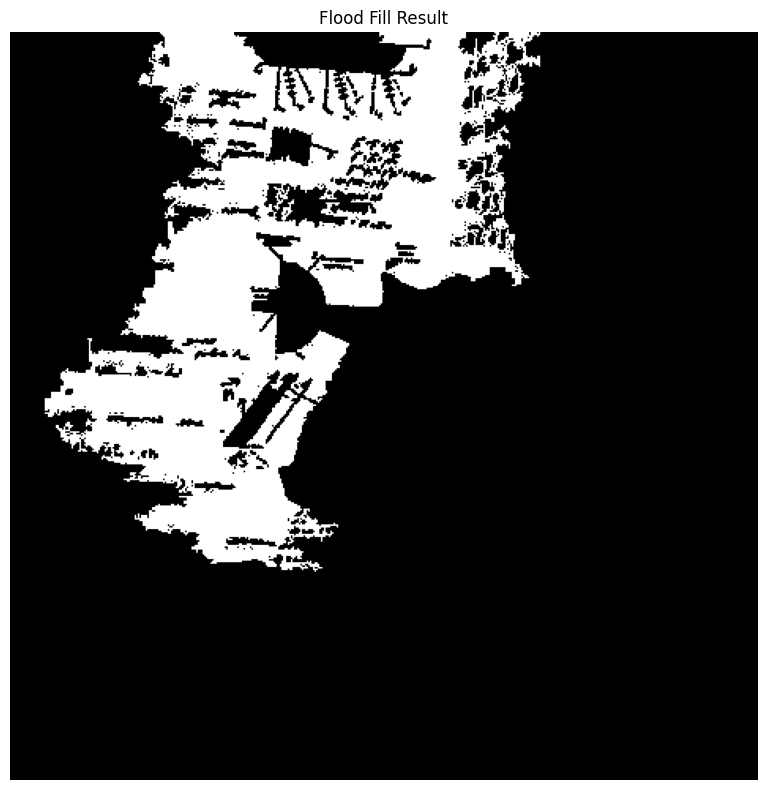

In [15]:
def flood_fill(img, seed=(50,50), thresh=15):
    h=len(img); w=len(img[0])
    result=[[0]*w for _ in range(h)]
    seed_val=img[seed[1]][seed[0]]
    stack=[seed]
    while stack:
        x,y=stack.pop()
        if x<0 or y<0 or x>=w or y>=h or result[y][x]==255: continue
        if abs(img[y][x]-seed_val)<=thresh:
            result[y][x]=255
            for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                stack.append((x+dx,y+dy))
    return result

seg_ff = flood_fill(gray_list, seed=(w//3,h//3))
show_images_grid([seg_ff], ["Flood Fill Result"])


K-Means: Clustering intensitas piksel menjadi beberapa kelompok.

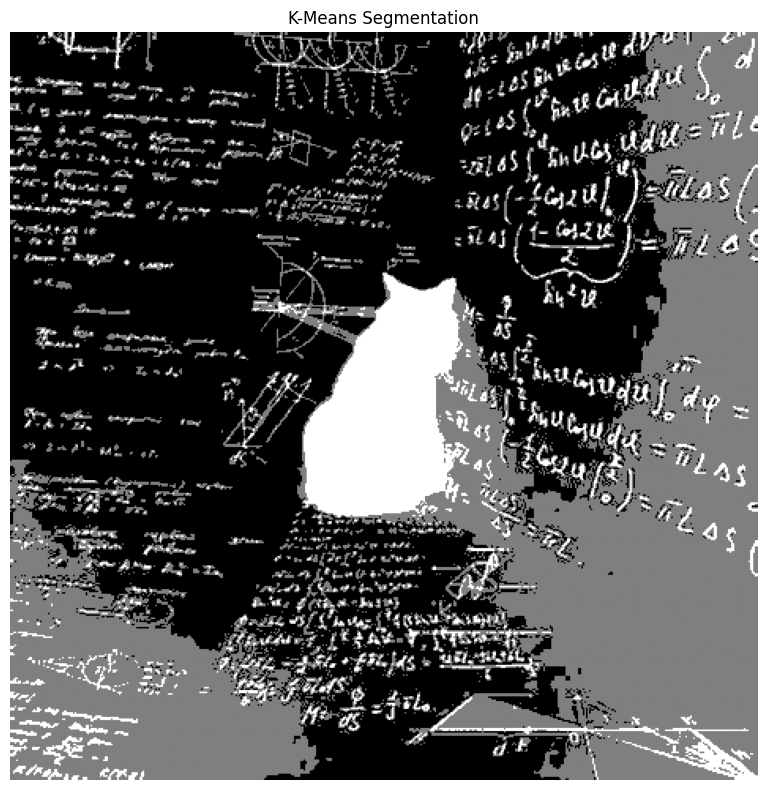

In [16]:
def kmeans_segmentation(img, k=3, max_iter=10):
    pixels=[p for row in img for p in row]
    centers=random.sample(pixels, k)
    for _ in range(max_iter):
        clusters=[[] for _ in range(k)]
        for p in pixels:
            idx=min(range(k), key=lambda i: abs(p-centers[i]))
            clusters[idx].append(p)
        new_centers=[sum(c)/len(c) if c else centers[i] for i,c in enumerate(clusters)]
        if all(abs(new_centers[i]-centers[i])<1 for i in range(k)): break
        centers=new_centers
    seg=[]
    for row in img:
        seg_row=[]
        for p in row:
            idx=min(range(k), key=lambda i: abs(p-centers[i]))
            seg_row.append(int(255*idx/(k-1)))
        seg.append(seg_row)
    return seg

seg_kmeans=kmeans_segmentation(gray_list, k=3)
show_images_grid([seg_kmeans], ["K-Means Segmentation"])


# Operasi Morfologi

Empat operasi diterapkan pada hasil segmentasi:

Dilation: Memperbesar area objek.

Erosion: Mengecilkan area objek.

Opening: Menghapus noise kecil di luar objek (Erosion → Dilation).

Closing: Menutup lubang kecil di dalam objek (Dilation → Erosion).

In [ ]:
# ==== MORPHOLOGICAL OPERATIONS ====
se = [[1,1,1],[1,1,1],[1,1,1]]

def dilation(img, se):
    h, w = len(img), len(img[0])
    out = [[0]*w for _ in range(h)]
    for y in range(1,h-1):
        for x in range(1,w-1):
            if any(img[y+dy-1][x+dx-1]==255 and se[dy][dx] for dy in range(3) for dx in range(3)):
                out[y][x]=255
    return out

def erosion(img, se):
    h, w = len(img), len(img[0])
    out = [[0]*w for _ in range(h)]
    for y in range(1,h-1):
        for x in range(1,w-1):
            if all((not se[dy][dx]) or img[y+dy-1][x+dx-1]==255 for dy in range(3) for dx in range(3)):
                out[y][x]=255
    return out

def opening(img, se): return dilation(erosion(img, se), se)
def closing(img, se): return erosion(dilation(img, se), se)

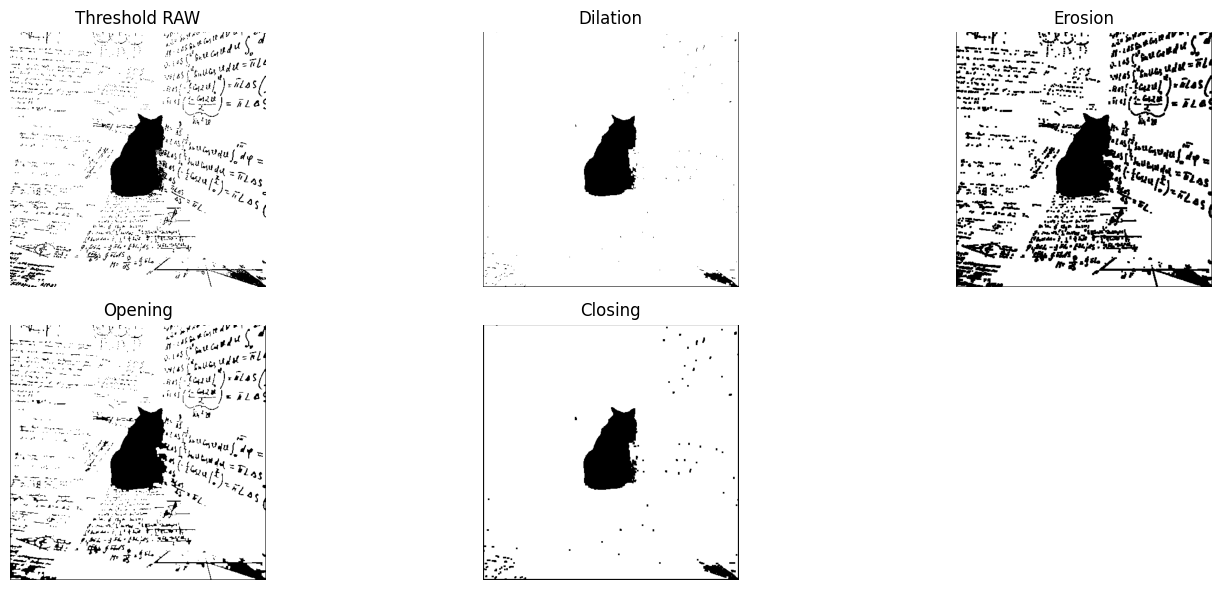

In [18]:
# Apply morphological operations to threshold segmentation
th_dil = dilation(seg_thresh, se)
th_ero = erosion(seg_thresh, se)
th_open = opening(seg_thresh, se)
th_close = closing(seg_thresh, se)

show_images_grid(
    [seg_thresh, th_dil, th_ero, th_open, th_close],
    ["Threshold RAW", "Dilation", "Erosion", "Opening", "Closing"],
    figsize=(15,6)
)


Threshold RAW:
Masih banyak noise dari tulisan di dinding; objek kucing terlihat tapi background berantakan.

Dilation:
Kucing solid, background paling bersih; ini hasil paling stabil dan rapi di antara semuanya.

Erosion:
Kucing sedikit menyusut, tapi noise di background muncul lagi; hasilnya kasar.

Opening:
Noise kecil hilang tanpa merusak bentuk kucing; hasil lebih halus tapi background masih agak ramai.

Closing:
Noise di sekitar hilang banyak; hasil lebih bersih tapi masih terlihat noise.

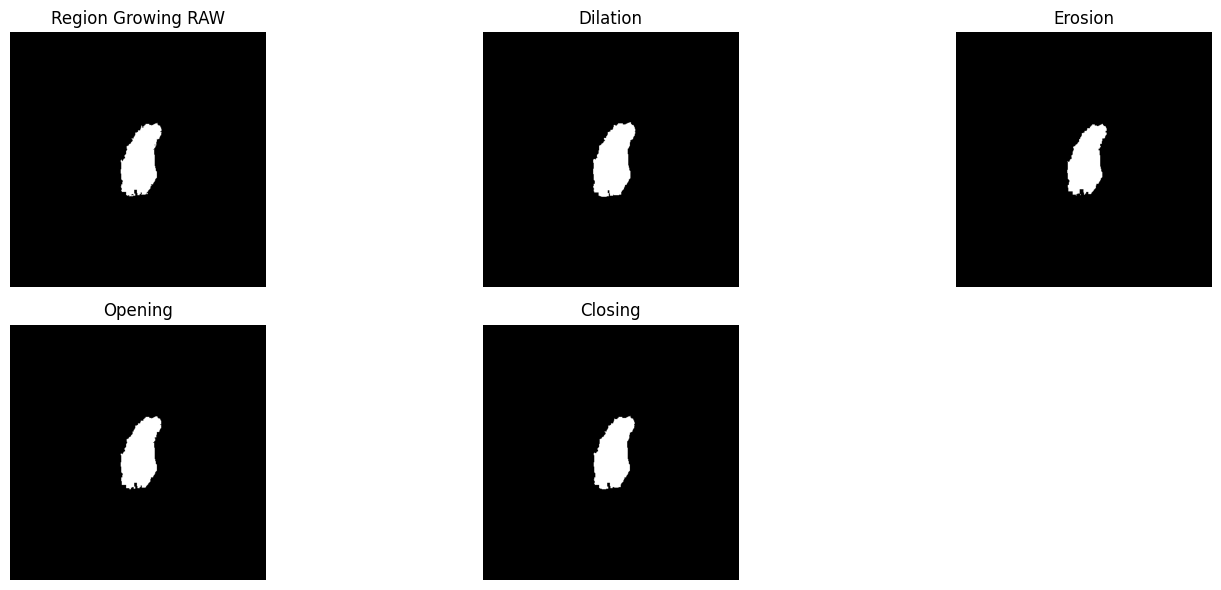

In [19]:
rg_dil = dilation(seg_rg, se)
rg_ero = erosion(seg_rg, se)
rg_open = opening(seg_rg, se)
rg_close = closing(seg_rg, se)

show_images_grid(
    [seg_rg, rg_dil, rg_ero, rg_open, rg_close],
    ["Region Growing RAW", "Dilation", "Erosion", "Opening", "Closing"],
    figsize=(15,6)
)


Region Growing RAW:
Objek utama (kucing) berhasil terisolasi dengan baik, bentuknya halus dan noise hampir gak ada.

Dilation:
Objek sedikit membesar, batas luar lebih tegas. Cocok buat menutup celah kecil di tepi objek.

Erosion:
Objek mengecil sedikit, bagian halus di pinggir mulai hilang.

Opening:
Hasil tetap bersih seperti aslinya, tapi ujung objek jadi sedikit lebih halus. Bagus untuk menghapus noise kecil tanpa ubah bentuk besar.

Closing:
Celah-celah kecil di permukaan tertutup rapat. Hasilnya paling solid dan tegas di antara semua operasi.

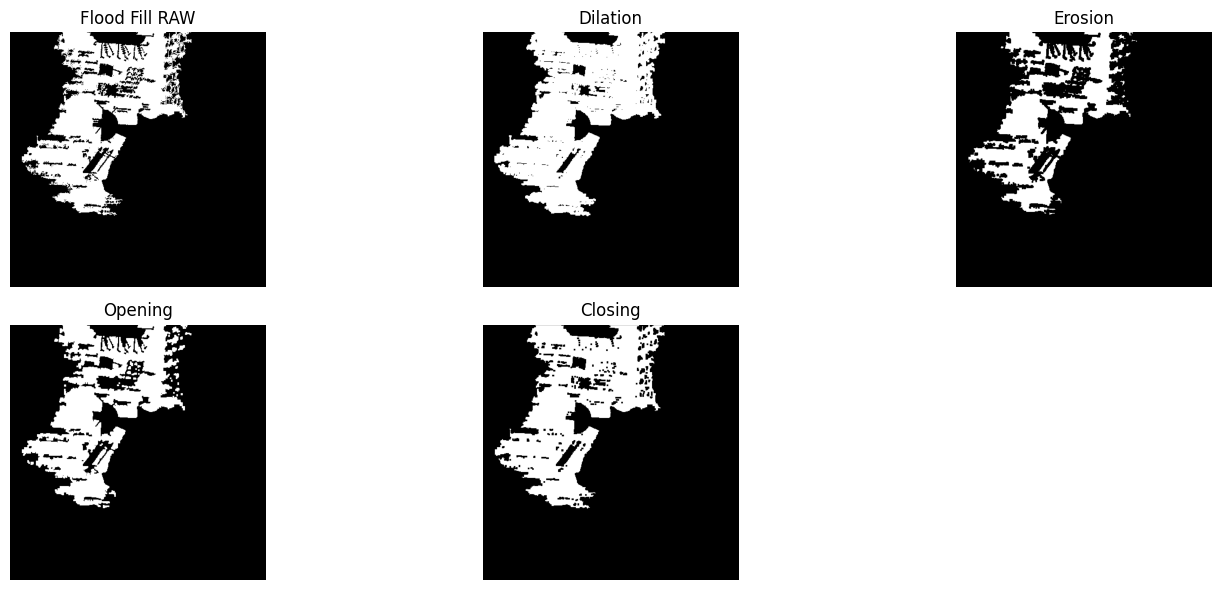

In [20]:
ff_dil = dilation(seg_ff, se)
ff_ero = erosion(seg_ff, se)
ff_open = opening(seg_ff, se)
ff_close = closing(seg_ff, se)

show_images_grid(
    [seg_ff, ff_dil, ff_ero, ff_open, ff_close],
    ["Flood Fill RAW", "Dilation", "Erosion", "Opening", "Closing"],
    figsize=(15,6)
)


Flood Fill RAW:
Citra berhasil menyorot area utama, tapi masih banyak bagian tulisan yang ikut keambil — segmentation-nya terlalu lebar.

Dilation:
Area putih (region) makin meluas dan saling menyatu, menyebabkan batas objek makin kabur.

Erosion:
Area putih menyusut, beberapa bagian objek jadi hilang, tapi noise agak berkurang.

Opening:
Noise kecil dihapus cukup efektif, meski beberapa detail objek ikut terkikis.

Closing:
Lubang-lubang kecil di dalam area putih tertutup, hasilnya lebih solid dan menyatu rapi dibanding versi awal.

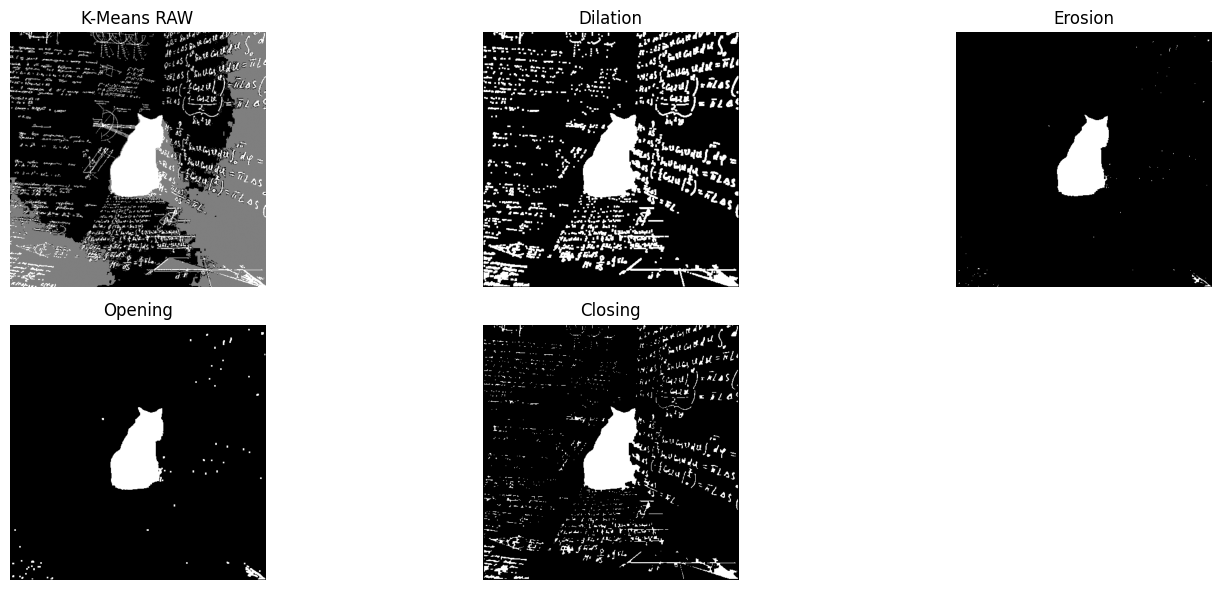

In [21]:
km_dil = dilation(seg_kmeans, se)
km_ero = erosion(seg_kmeans, se)
km_open = opening(seg_kmeans, se)
km_close = closing(seg_kmeans, se)

show_images_grid(
    [seg_kmeans, km_dil, km_ero, km_open, km_close],
    ["K-Means RAW", "Dilation", "Erosion", "Opening", "Closing"],
    figsize=(15,6)
)


K-Means RAW:
Objek kucing terpisah cukup baik dari background, tapi area sekitar masih punya variasi warna yang belum bersih.

Dilation:
Batas kucing jadi lebih jelas dan menyatu, tapi noise dari tulisan ikut menguat — hasil jadi lebih ramai.

Erosion:
Hasil paling bersih; kucing tetap utuh dan background makin minimal.

Opening:
Kucing sedikit mengecil, tapi background jadi lebih gelap dan rapi; noise banyak berkurang.

Closing:
Kucing tampak solid dan tegas, tapi background masih agak ramai. Hasil ini bagus kalau mau mempertahankan bentuk objek secara utuh.